In [42]:
print(">>> [Test Cell 03] Bắt đầu chạy...")

import pandas as pd
import numpy as np
import os
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import copy

# --- Bỏ qua các cảnh báo (cho gọn) ---
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning) # Tắt cảnh báo Overflow (nếu có)

>>> [Test Cell 03] Bắt đầu chạy...


In [43]:
print("[Cell] Đang thiết lập cấu hình...")

# SỬA LỖI PATH: Dùng os.getcwd() thay vì __file__
try:
    # Giả định notebook này nằm trong thư mục /notebooks
    CURRENT_DIR = os.getcwd() 
    ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
    
    # Định nghĩa các đường dẫn
    PROCESSED_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_clean.csv')
    REPORTS_DIR = os.path.join(ROOT_DIR, 'reports')
    FIGURES_DIR = os.path.join(REPORTS_DIR, 'figures')
    RESULTS_DIR = os.path.join(REPORTS_DIR, 'results')
    
    # Hằng số
    RANDOM_STATE = 42
    TEST_SIZE = 0.3
    
    print(f"Đường dẫn file dữ liệu: {PROCESSED_DATA_PATH}")

except Exception as e:
    print(f"Lỗi khi thiết lập đường dẫn: {e}")
    print("Hãy đảm bảo bạn đang chạy notebook này từ thư mục /notebooks")

[Cell] Đang thiết lập cấu hình...
Đường dẫn file dữ liệu: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\data\processed\dataset_clean.csv


In [44]:
print("[Cell] Đang định nghĩa lớp CustomMLPRegressor và hàm PCA...")

# --- Hàm kích hoạt (Activation Functions) và đạo hàm ---
def leaky_relu(Z, alpha=0.01):
    """
    Hàm kích hoạt Leaky ReLU.
    Trả về Z nếu Z > 0, trả về alpha*Z nếu Z <= 0.
    """
    return np.maximum(alpha * Z, Z)

def leaky_relu_derivative(Z, alpha=0.01):
    """Đạo hàm của Leaky ReLU."""
    dZ = np.ones_like(Z)
    # Nơi Z < 0, đạo hàm là 'alpha'
    dZ[Z < 0] = alpha
    return dZ

def linear(Z):
    """Hàm kích hoạt tuyến tính (không làm gì cả)"""
    return Z

def linear_derivative(Z):
    """Đạo hàm của hàm tuyến tính (luôn là 1)"""
    return np.ones_like(Z)

def apply_pca(X_train, X_test, n_components=0.95):
    """
    Áp dụng PCA để giảm chiều dữ liệu.
    """
    # Khởi tạo PCA. n_components=0.95 nghĩa là giữ lại 95% phương sai
    # (Chúng ta dùng RANDOM_STATE đã định nghĩa ở Cell 2)
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    
    # Fit và transform trên tập train
    X_train_pca = pca.fit_transform(X_train)
    
    # Chỉ transform trên tập test
    X_test_pca = pca.transform(X_test)
    
    print(f"PCA: Đã giảm từ {X_train.shape[1]} xuống {pca.n_components_} chiều (giữ {n_components*100}% phương sai).")
    return X_train_pca, X_test_pca
# --- KẾT THÚC THÊM HÀM ---

# --- Lớp Custom MLP Regressor (Nhiệm vụ 2) ---
class CustomMLPRegressor:
    """
    MLPRegressor cho Hồi quy (Nâng cấp)
    - Optimizer: Adam
    - Regularization: Early Stopping + L2 Regularization (Weight Decay)
    - Activation: Leaky ReLU (thay cho ReLU)
    - Initialization: He (thay cho Xavier)
    """
    
    def __init__(self, layer_dims, learning_rate=0.001, epochs=2000, batch_size=32,
                 beta1=0.9, beta2=0.999, epsilon=1e-8, 
                 lambd=0.0, alpha=0.01, # <<< ### CẢI TIẾN MỚI ###
                 early_stopping=True, patience=20, validation_fraction=0.1,
                 random_state=42):
        """
        Khởi tạo MLP Regressor (Nâng cấp).
        
        --- Siêu tham số MỚI (L2 và Leaky ReLU) ---
        - lambd (float): Hệ số L2 regularization (ví dụ: 0.01, 0.1). 
                          Mặc định 0.0 (không dùng L2).
        - alpha (float): Độ dốc của Leaky ReLU (thường là 0.01).
        """
        np.random.seed(random_state)
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        
        # Tham số Adam
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # --- ### CẢI TIẾN 2A & 3B: Lưu tham số mới ### ---
        self.lambd = lambd  # Hệ số L2
        self.alpha = alpha  # Độ dốc Leaky ReLU
        
        # Tham số Early Stopping
        self.early_stopping = early_stopping
        self.patience = patience
        self.validation_fraction = validation_fraction

        self.parameters = {}
        self.costs = []
        self.val_costs = []
        
        # Khởi tạo bộ tích lũy (accumulators) cho Adam
        self.m = {} 
        self.s = {} 
        self.t = 0  
        
        for l in range(1, len(self.layer_dims)):
            input_dim = self.layer_dims[l-1]
            output_dim = self.layer_dims[l]
            
            # --- ### CẢI TIẾN 3A: KHỞI TẠO HE (cho (Leaky) ReLU) ### ---
            # Thay vì Xavier (sqrt(1./input_dim)), dùng He (sqrt(2./input_dim))
            self.parameters[f'W{l}'] = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim) 
            self.parameters[f'b{l}'] = np.zeros((1, output_dim))
            
            # Khởi tạo m và s cho Adam
            self.m[f'dW{l}'] = np.zeros_like(self.parameters[f'W{l}'])
            self.m[f'db{l}'] = np.zeros_like(self.parameters[f'b{l}'])
            self.s[f'dW{l}'] = np.zeros_like(self.parameters[f'W{l}'])
            self.s[f'db{l}'] = np.zeros_like(self.parameters[f'b{l}'])

    def _compute_loss(self, A_last, Y):
        """Tính hàm mất mát Mean Squared Error (MSE) + L2 Regularization Cost"""
        m = Y.shape[0]
        if m == 0:
            return 0.0
        
        # 1. Tính MSE Loss (Loss chính)
        mse_cost = (1 / (2 * m)) * np.sum(np.square(A_last - Y))
        
        # --- ### CẢI TIẾN 2A: TÍNH L2 REGULARIZATION COST ### ---
        l2_cost = 0.0
        if self.lambd > 0:
            L = len(self.layer_dims) - 1
            for l in range(1, L + 1):
                # Chỉ "trừng phạt" trọng số W, không trừng phạt bias b
                l2_cost += np.sum(np.square(self.parameters[f'W{l}']))
        
        # Công thức L2 cost: (lambda / 2m) * sum(W^2)
        total_cost = mse_cost + (self.lambd / (2 * m)) * l2_cost
        
        return np.squeeze(total_cost)

    def _feedforward(self, X):
        """Lan truyền tiến (Sử dụng Leaky ReLU)"""
        cache = {'A0': X}
        A = X
        L = len(self.layer_dims) - 1
        
        for l in range(1, L): # Lớp ẩn
            Z = np.dot(A, self.parameters[f'W{l}']) + self.parameters[f'b{l}']
            # --- ### CẢI TIẾN 3B: SỬ DỤNG LEAKY RELU ### ---
            A = leaky_relu(Z, self.alpha)
            cache[f'Z{l}'] = Z
            cache[f'A{l}'] = A
        
        # Lớp output (Linear)
        ZL = np.dot(A, self.parameters[f'W{L}']) + self.parameters[f'b{L}']
        A_last = linear(ZL) 
        cache[f'Z{L}'] = ZL
        cache[f'A{L}'] = A_last
        
        return A_last, cache

    def _backpropagate(self, A_last, Y, cache):
        """Lan truyền ngược (Sử dụng Leaky ReLU và L2 Gradient)"""
        gradients = {}
        m = Y.shape[0]
        L = len(self.layer_dims) - 1
        Y = Y.reshape(A_last.shape)

        # Lớp Output (L) (Linear + MSE)
        dZ_last = (A_last - Y) 
        A_prev = cache[f'A{L-1}']
        
        # --- ### CẢI TIẾN 2A: THÊM L2 GRADIENT CHO dW ### ---
        # Đạo hàm của L2 cost: (lambda / m) * W
        l2_grad_W_L = (self.lambd / m) * self.parameters[f'W{L}']
        
        gradients[f'dW{L}'] = (1/m) * np.dot(A_prev.T, dZ_last) + l2_grad_W_L
        gradients[f'db{L}'] = (1/m) * np.sum(dZ_last, axis=0, keepdims=True)
        dA_prev = np.dot(dZ_last, self.parameters[f'W{L}'].T)

        # Lớp Ẩn (L-1 đến 1)
        for l in reversed(range(1, L)):
            Z = cache[f'Z{l}']
            
            # --- ### CẢI TIẾN 3B: SỬ DỤNG ĐẠO HÀM LEAKY RELU ### ---
            dZ = dA_prev * leaky_relu_derivative(Z, self.alpha)
            A_prev = cache[f'A{l-1}']
            
            # --- ### CẢI TIẾN 2A: THÊM L2 GRADIENT CHO dW ### ---
            l2_grad_W_l = (self.lambd / m) * self.parameters[f'W{l}']
            
            gradients[f'dW{l}'] = (1/m) * np.dot(A_prev.T, dZ) + l2_grad_W_l
            gradients[f'db{l}'] = (1/m) * np.sum(dZ, axis=0, keepdims=True)
            
            if l > 1:
                dA_prev = np.dot(dZ, self.parameters[f'W{l}'].T)
                
        return gradients

    def _update_weights_adam(self, gradients):
        """Cập nhật trọng số bằng ADAM (Giữ nguyên, không cần thay đổi)"""
        
        self.t += 1 
        L = len(self.layer_dims) - 1
        
        for l in range(1, L + 1):
            W_key, b_key = f'W{l}', f'b{l}'
            dW_key, db_key = f'dW{l}', f'db{l}'

            # --- Cập nhật cho W{l} ---
            self.m[dW_key] = self.beta1 * self.m[dW_key] + (1 - self.beta1) * gradients[dW_key]
            self.s[dW_key] = self.beta2 * self.s[dW_key] + (1 - self.beta2) * np.square(gradients[dW_key])
            m_corrected = self.m[dW_key] / (1 - self.beta1**self.t)
            s_corrected = self.s[dW_key] / (1 - self.beta2**self.t)
            self.parameters[W_key] -= self.learning_rate * m_corrected / (np.sqrt(s_corrected) + self.epsilon)

            # --- Cập nhật cho b{l} ---
            self.m[db_key] = self.beta1 * self.m[db_key] + (1 - self.beta1) * gradients[db_key]
            self.s[db_key] = self.beta2 * self.s[db_key] + (1 - self.beta2) * np.square(gradients[db_key])
            m_b_corrected = self.m[db_key] / (1 - self.beta1**self.t)
            s_b_corrected = self.s[db_key] / (1 - self.beta2**self.t)
            self.parameters[b_key] -= self.learning_rate * m_b_corrected / (np.sqrt(s_b_corrected) + self.epsilon)

    def fit(self, X_full, Y_full, batch_size=None, verbose=True):
        """
        Huấn luyện mô hình (Giữ nguyên, không cần thay đổi)
        (Tự động tách validation, chạy Adam, và Early Stopping)
        """
        
        if batch_size is None:
            batch_size = self.batch_size 
        
        if Y_full.ndim == 1:
            Y_full = Y_full.reshape(-1, 1)

        X_train, Y_train = X_full, Y_full
        X_val, Y_val_reshaped = None, None
        
        if self.early_stopping:
            print(f"[EarlyStopping] Tách {self.validation_fraction*100}% dữ liệu làm validation (patience={self.patience}).")
            X_train, X_val, Y_train, Y_val_flat = train_test_split(
                X_full, Y_full, 
                test_size=self.validation_fraction, 
                random_state=self.random_state
            )
            Y_val_reshaped = Y_val_flat.reshape(-1, 1)

        m = X_train.shape[0]
        
        print(f"Bắt đầu huấn luyện Custom MLP (He, Leaky, L2={self.lambd}) với {self.epochs} epochs (batch_size={batch_size})...")
        print(f"Số mẫu huấn luyện: {m}")
        
        best_val_loss = np.inf
        patience_counter = 0
        best_parameters = {}
        
        self.costs = []
        self.val_costs = []

        try:
            for i in range(self.epochs):
                epoch_cost = 0.0
                
                permutation = np.random.permutation(m)
                X_shuffled = X_train[permutation]
                Y_shuffled = Y_train[permutation]

                for j in range(0, m, batch_size):
                    X_batch = X_shuffled[j : j + batch_size]
                    Y_batch = Y_shuffled[j : j + batch_size]
                    
                    A_last, cache = self._feedforward(X_batch)
                    cost = self._compute_loss(A_last, Y_batch)
                    epoch_cost += cost * X_batch.shape[0] 
                    
                    gradients = self._backpropagate(A_last, Y_batch, cache)
                    self._update_weights_adam(gradients)
                
                avg_train_cost = epoch_cost / m
                self.costs.append(avg_train_cost)
                
                val_loss_str = "N/A"
                if self.early_stopping:
                    A_last_val, _ = self._feedforward(X_val)
                    val_loss = self._compute_loss(A_last_val, Y_val_reshaped)
                    self.val_costs.append(val_loss)
                    val_loss_str = f"{val_loss:.6f}"
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_parameters = copy.deepcopy(self.parameters) 
                    else:
                        patience_counter += 1
                        
                    if patience_counter >= self.patience:
                        print(f"\n--- EARLY STOPPING KÍCH HOẠT ---")
                        print(f"Epoch {i+1}: Validation loss không cải thiện trong {self.patience} epochs.")
                        print(f"Hoàn tất huấn luyện. Loss tốt nhất: {best_val_loss:.6f}")
                        break
                
                if verbose and (i % 200 == 0 or i == self.epochs - 1):
                    print(f"Epoch {i+1}/{self.epochs}, Train Cost: {avg_train_cost:.6f}, Val Cost: {val_loss_str}")
            
            if verbose:
                print("Huấn luyện hoàn tất (hoặc đã dừng sớm).")
        
        except (KeyboardInterrupt, OverflowError) as e:
            print(f"\nĐã dừng huấn luyện: {e}")
            
        if self.early_stopping and best_parameters:
            print(f"Khôi phục trọng số từ epoch có val_loss tốt nhất ({best_val_loss:.6f}).")
            self.parameters = best_parameters

    def predict(self, X):
        """Dự đoán giá trị hồi quy (Giữ nguyên)"""
        A_last, _ = self._feedforward(X)
        return A_last

[Cell] Đang định nghĩa lớp CustomMLPRegressor và hàm PCA...


In [45]:
print("[Cell] Đang định nghĩa hàm đánh giá...")

# *** ĐÃ CẬP NHẬT (Thêm MSE + RMSE) ***
def get_regression_metrics(y_true, y_pred, title="Model"):
    """
    Tính toán, in và lưu báo cáo hồi quy, vẽ biểu đồ phân tán.
    """
    y_true_np = y_true.to_numpy() if isinstance(y_true, pd.Series) else np.array(y_true).ravel()
    y_pred_np = np.array(y_pred).ravel()

    r2 = r2_score(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np) # TÍNH TOÁN MSE
    rmse = np.sqrt(mse) # TÍNH TOÁN RMSE
    
    print("\n" + "-"*30)
    print(f"KẾT QUẢ ĐÁNH GIÁ CHO: {title}")
    print(f"R-Squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}") # IN MSE
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}") # IN RMSE
    print("-" * 30)

    # ... (Toàn bộ code vẽ biểu đồ giữ nguyên) ...
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true_np, y=y_pred_np, alpha=0.5)
    lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0) 
    plt.title(f'Predicted vs. Actual - {title}')
    plt.xlabel('Giá trị Thực tế (Actual Revenue)')
    plt.ylabel('Giá trị Dự đoán (Predicted Revenue)')
    plt.xlim(lims)
    plt.ylim(lims)
    
    os.makedirs(FIGURES_DIR, exist_ok=True)
    fig_path = os.path.join(FIGURES_DIR, f'scatter_{title.lower().replace(" ", "_")}.png')
    
    try:
        plt.savefig(fig_path)
        print(f"Đã lưu biểu đồ phân tán tại: {fig_path}")
    except Exception as e:
        print(f"Lỗi khi lưu hình ảnh: {e}")
        
    plt.show() 
    
    # THÊM MSE/RMSE VÀO KẾT QUẢ TRẢ VỀ
    return {"R-Squared": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}


[Cell] Đang định nghĩa hàm đánh giá...


In [46]:
print("\n[Cell] Đang tải và chuẩn bị dữ liệu...")

if not os.path.exists(PROCESSED_DATA_PATH):
    print(f"LỖI: Không tìm thấy file {PROCESSED_DATA_PATH}")
    print("Vui lòng chạy 'python src/data_processing.py' trước để tạo file này.")
else:
    print(f"Đang tải dữ liệu đã xử lý từ: {PROCESSED_DATA_PATH}")
    data = pd.read_csv(PROCESSED_DATA_PATH)

    target_col = 'Revenue_(USD)' 
    X = data.drop(columns=[target_col])
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, 
        random_state=RANDOM_STATE
    )

    # --- Scale Dữ liệu X (Sử dụng RobustScaler) ---
    scaler_x = RobustScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    # --- Scale Dữ liệu y (Target) ---
    # Rất quan trọng cho MLP Regressor để hội tụ tốt
    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    # y_test (gốc) được giữ nguyên để đánh giá cuối cùng
    
    print("Chuẩn bị dữ liệu hoàn tất.")


[Cell] Đang tải và chuẩn bị dữ liệu...
Đang tải dữ liệu đã xử lý từ: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\data\processed\dataset_clean.csv
Chuẩn bị dữ liệu hoàn tất.



[Cell] Đang huấn luyện: 1. Custom MLP (Full Features - Tối ưu L2)...
[EarlyStopping] Tách 10.0% dữ liệu làm validation (patience=500).
Bắt đầu huấn luyện Custom MLP (He, Leaky, L2=0.05) với 5000 epochs (batch_size=128)...
Số mẫu huấn luyện: 712
Epoch 1/5000, Train Cost: 10.191234, Val Cost: 2.550378
Epoch 201/5000, Train Cost: 0.153354, Val Cost: 0.396214
Epoch 401/5000, Train Cost: 0.103647, Val Cost: 0.459045
Epoch 601/5000, Train Cost: 0.089223, Val Cost: 0.372578
Epoch 801/5000, Train Cost: 0.067040, Val Cost: 0.363744
Epoch 1001/5000, Train Cost: 0.087744, Val Cost: 0.331303
Epoch 1201/5000, Train Cost: 0.068431, Val Cost: 0.307243
Epoch 1401/5000, Train Cost: 0.060675, Val Cost: 0.290495
Epoch 1601/5000, Train Cost: 0.144557, Val Cost: 0.398205
Epoch 1801/5000, Train Cost: 0.052818, Val Cost: 0.359861

--- EARLY STOPPING KÍCH HOẠT ---
Epoch 1913: Validation loss không cải thiện trong 500 epochs.
Hoàn tất huấn luyện. Loss tốt nhất: 0.205335
Huấn luyện hoàn tất (hoặc đã dừng sớm).

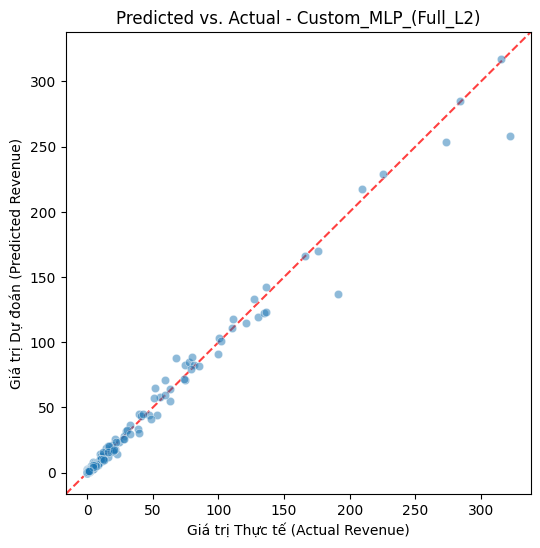

In [47]:
# %%
results_list = []
print("\n[Cell] Đang huấn luyện: 1. Custom MLP (Full Features - Tối ưu L2)...")

# (Đảm bảo Lớp CustomMLPRegressor và hàm Leaky ReLU mới đã được định nghĩa ở cell trên)

# Cấu hình các tham số mới
mlp_params_full_op = {
    'layer_dims': [X_train_scaled.shape[1], 128, 64, 1],
    'learning_rate': 0.002, # Thử giảm learning rate khi dùng L2
    'epochs': 5000,          
    'batch_size': 128,
    'random_state': RANDOM_STATE,
    
    # --- Tham số Adam (Giữ nguyên) ---
    'beta1': 0.9,
    'beta2': 0.999,
    
    # --- Tham số MỚI ---
    'lambd': 0.05,           # <<< THÊM L2 REGULARIZATION (Giá trị khởi điểm tốt)
    'alpha': 0.01,           # <<< Dùng Leaky ReLU (mặc định)
    
    # --- Tham số Early Stopping ---
    'early_stopping': True,
    'patience': 500,          
    'validation_fraction': 0.1 
}
mlp_full_op = CustomMLPRegressor(**mlp_params_full_op)

# Fit trên dữ liệu đã scale
mlp_full_op.fit(X_train_scaled, y_train_scaled, verbose=True) 

# Phần dự đoán và đánh giá giữ nguyên
y_pred_scaled_mlp_full = mlp_full_op.predict(X_test_scaled)
y_pred_mlp_full = scaler_y.inverse_transform(y_pred_scaled_mlp_full)

metrics_mlp_full = get_regression_metrics(y_test, y_pred_mlp_full, title="Custom_MLP_(Full_L2)")

# (Thêm kết quả vào results_list...)
results_list.append({
    'Model': f'Custom MLP (L2={mlp_params_full_op["lambd"]})',
    'Features': 'Full',
    'R-Squared': metrics_mlp_full['R-Squared'],
    'MAE': metrics_mlp_full['MAE'],
    'MSE': metrics_mlp_full['MSE'],
    'RMSE': metrics_mlp_full['RMSE']
})


[Cell] Đang huấn luyện: 2. Custom MLP (PCA Features - Tối ưu L2)...
PCA: Đã giảm từ 13 xuống 2 chiều (giữ 95.0% phương sai).
[EarlyStopping] Tách 10.0% dữ liệu làm validation (patience=500).
Bắt đầu huấn luyện Custom MLP (He, Leaky, L2=0.05) với 5000 epochs (batch_size=32)...
Số mẫu huấn luyện: 712

--- EARLY STOPPING KÍCH HOẠT ---
Epoch 749: Validation loss không cải thiện trong 500 epochs.
Hoàn tất huấn luyện. Loss tốt nhất: 0.427343
Khôi phục trọng số từ epoch có val_loss tốt nhất (0.427343).

------------------------------
KẾT QUẢ ĐÁNH GIÁ CHO: Custom_MLP_(PCA_L2)
R-Squared (R²): 0.9597
Mean Absolute Error (MAE): 3.1219
Mean Squared Error (MSE): 83.8384
Root Mean Squared Error (RMSE): 9.1563
------------------------------
Đã lưu biểu đồ phân tán tại: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\reports\figures\scatter_custom_mlp_(pca_l2).png


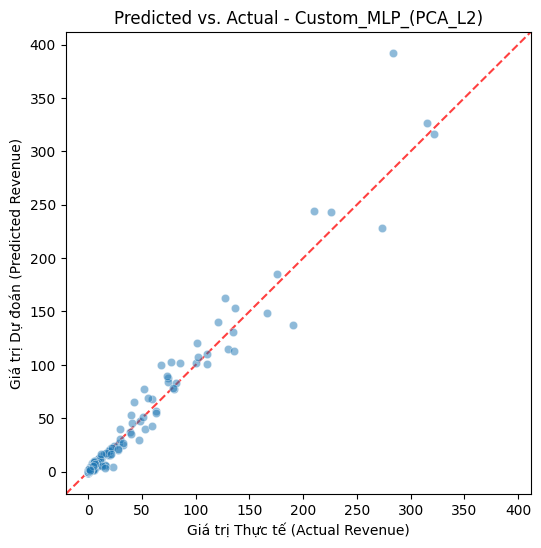

In [48]:
print("\n[Cell] Đang huấn luyện: 2. Custom MLP (PCA Features - Tối ưu L2)...")

# Áp dụng PCA (Giữ nguyên)
X_train_pca_unscaled, X_test_pca_unscaled = apply_pca(X_train_scaled, X_test_scaled, n_components=0.95)

# Scale lại đầu ra PCA (Giữ nguyên)
pca_scaler = RobustScaler()
X_train_pca_scaled = pca_scaler.fit_transform(X_train_pca_unscaled)
X_test_pca_scaled = pca_scaler.transform(X_test_pca_unscaled)

# --- CẤU TRÚC ĐÃ CẬP NHẬT (Giống file Full) ---
mlp_params_pca_op = {
    'layer_dims': [X_train_pca_scaled.shape[1], 16, 1], # Giữ kiến trúc đơn giản cho PCA
    'learning_rate': 0.002,  # Đồng bộ learning rate với mô hình Full
    'epochs': 5000,          
    'batch_size': 32,
    'random_state': RANDOM_STATE,
    
    # --- Tham số Adam (Giữ nguyên) ---
    'beta1': 0.9,
    'beta2': 0.999,
    
    # --- THÊM CÁC THAM SỐ ROBUST TỪ MÔ HÌNH FULL ---
    'lambd': 0.05,           # <<< THÊM L2 (Giá trị này có thể cần tune lại riêng cho PCA)
    'alpha': 0.01,           # <<< THÊM Leaky ReLU
    
    # --- Tham số Early Stopping (Giữ nguyên) ---
    'early_stopping': True,
    'patience': 500,
    'validation_fraction': 0.1 
}

mlp_pca_op = CustomMLPRegressor(**mlp_params_pca_op)

# Fit trên dữ liệu PCA đã scale
# Giữ verbose=False như ý định ban đầu của bạn
mlp_pca_op.fit(X_train_pca_scaled, y_train_scaled, verbose=False) 

# --- SỬ DỤNG CÙNG PHƯƠNG THỨC INVERSE TRANSFORM VỚI MÔ HÌNH FULL ---
y_pred_scaled_mlp_pca = mlp_pca_op.predict(X_test_pca_scaled)
# (Giả định y_train_scaled được tạo bởi scaler_y, giống mô hình Full)
y_pred_mlp_pca = scaler_y.inverse_transform(y_pred_scaled_mlp_pca)

# Đánh giá (cập nhật title)
metrics_mlp_pca = get_regression_metrics(y_test, y_pred_mlp_pca, title="Custom_MLP_(PCA_L2)")

# --- CẬP NHẬT TÊN MODEL ĐỂ ĐỒNG BỘ ---
results_list.append({
    'Model': f'Custom MLP (L2={mlp_params_pca_op["lambd"]})', # Đồng bộ cấu trúc tên
    'Features': 'PCA',
    'R-Squared': metrics_mlp_pca['R-Squared'],
    'MAE': metrics_mlp_pca['MAE'],
    'MSE': metrics_mlp_pca['MSE'],
    'RMSE': metrics_mlp_pca['RMSE']
})

In [49]:
print("\n[Cell] HOÀN TẤT: Lưu kết quả ra file JSON...")

os.makedirs(RESULTS_DIR, exist_ok=True)
# LƯU VÀO FILE RIÊNG
output_path = os.path.join(RESULTS_DIR, 'mlp_results.json')

with open(output_path, 'w') as f:
    json.dump(results_list, f, indent=4)
    
print(f"Đã lưu kết quả của Custom MLP tại: {output_path}")

print("\nBảng kết quả tổng hợp (Custom MLP):")
display(pd.DataFrame(results_list))

print("\n>>> [Test Cell 03] Đã chạy xong.")


[Cell] HOÀN TẤT: Lưu kết quả ra file JSON...
Đã lưu kết quả của Custom MLP tại: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\reports\results\mlp_results.json

Bảng kết quả tổng hợp (Custom MLP):


,Model,Features,R-Squared,MAE,MSE,RMSE
0,Custom MLP (L2=0.05),Full,0.985944,1.760024,29.273683,5.410516
1,Custom MLP (L2=0.05),PCA,0.959745,3.121886,83.838448,9.156334



>>> [Test Cell 03] Đã chạy xong.
